since -red was highly unsuccessful on DEFAULT=1, need to figure out what correlates to that.
original plot was too biased

In [11]:
### ref https://blog.jovian.ai/machine-learning-with-python-implementing-xgboost-and-random-forest-fd51fa4f9f4c#b9a9
# !pip install numpy pandas matplotlib seaborn --quiet
# !pip install jovian opendatasets xgboost graphviz lightgbm scikit-learn xgboost lightgbm --upgrade --quiet
# !pip install pyreadr

#importing dataset
import os
# import opendatasets as od
import pandas as pd
import numpy as np
import pyreadr

#Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

# For Missing Value and Feature Engineering
from sklearn.feature_selection import SelectKBest, chi2, f_classif, VarianceThreshold
from sklearn.impute import SimpleImputer, KNNImputer, MissingIndicator
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn import metrics

import time

#for visualization
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 120)
pd.set_option("display.max_rows", 120)


In [12]:
credit_card_default_raw = pd.read_csv('./Data/credit_card_default.csv')
# credit_card_default_eng = pd.read_csv('./Data/credit_card_default_eng.csv')
result = pyreadr.read_r('./Data/credit_card_default_eng_features.RData') 
credit_card_default_eng = result[None]
# credit_card_default_eng.set_index('Unnamed: 0', inplace=True)
display(credit_card_default_eng.describe())
display(credit_card_default_eng.head())

,age_bins,bill_avg,payment_avg,ratio_avg,util_avg,balance_growth_6mo,bill_max,payment_max,pay_max
count,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,3.000000e+04,30000.000000
mean,3.99390,44976.945200,5275.232094,0.576423,0.375468,-0.090664,6.057244e+04,1.584823e+04,0.682200
std,0.95845,63260.721860,10137.946323,16.499616,0.355618,0.279674,7.840481e+04,3.793356e+04,1.073518
min,3.00000,-56043.166667,0.000000,0.000000,-0.232590,-4.700400,-6.029000e+03,0.000000e+00,0.000000
25%,3.00000,4781.333333,1113.291667,0.047855,0.028925,-0.146863,1.006000e+04,2.198000e+03,0.000000
50%,4.00000,21051.833333,2397.166667,0.197668,0.286554,-0.004382,3.120850e+04,5.000000e+03,0.000000
75%,5.00000,57104.416667,5583.916667,0.903817,0.692718,0.028105,7.959900e+04,1.210000e+04,2.000000
max,8.00000,877313.833333,627344.333333,2667.199955,5.537758,1.791100,1.664089e+06,1.684259e+06,8.000000


,age_bins,bill_avg,payment_avg,ratio_avg,util_avg,balance_growth_6mo,bill_max,payment_max,pay_max
0,3.0,1284.000000,114.833333,0.800000,0.064200,-0.195650,3913.0,689.0,2.0
1,3.0,2846.166667,833.333333,0.193583,0.023987,0.006442,3455.0,2000.0,2.0
2,4.0,16942.166667,1836.333333,0.083968,0.187133,-0.158789,29239.0,5000.0,0.0
3,4.0,38555.666667,1398.000000,0.039794,0.769153,-0.360620,49291.0,2019.0,0.0
4,6.0,18223.166667,9841.500000,0.471997,0.364513,0.210580,35835.0,36681.0,0.0


In [13]:
# clean data?
credit_card_default = credit_card_default_eng.copy()
df_flags = credit_card_default_raw[['data.group', 'DEFAULT']]
df_other_features = credit_card_default_raw[['SEX','EDUCATION','MARRIAGE','AGE']]
credit_card_default = credit_card_default.join(df_flags)
credit_card_default = credit_card_default.join(df_other_features)
credit_card_default

,age_bins,bill_avg,payment_avg,ratio_avg,util_avg,balance_growth_6mo,bill_max,payment_max,pay_max,data.group,DEFAULT,SEX,EDUCATION,MARRIAGE,AGE
0,3.0,1284.000000,114.833333,0.800000,0.064200,-0.195650,3913.0,689.0,2.0,1,1,2,2,1,24
1,3.0,2846.166667,833.333333,0.193583,0.023987,0.006442,3455.0,2000.0,2.0,3,1,2,2,2,26
2,4.0,16942.166667,1836.333333,0.083968,0.187133,-0.158789,29239.0,5000.0,0.0,1,0,2,2,2,34
3,4.0,38555.666667,1398.000000,0.039794,0.769153,-0.360620,49291.0,2019.0,0.0,3,0,2,2,1,37
4,6.0,18223.166667,9841.500000,0.471997,0.364513,0.210580,35835.0,36681.0,0.0,3,0,1,2,1,57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,4.0,120891.500000,7091.666667,0.121471,0.561065,-0.716868,208365.0,20000.0,0.0,1,0,1,3,1,39
29996,5.0,3530.333333,2415.000000,0.807750,0.029302,0.023380,8979.0,8998.0,0.0,3,0,1,3,2,43
29997,4.0,11749.333333,5216.666667,0.272225,0.398450,0.567233,20878.0,22000.0,4.0,2,1,1,2,2,37
29998,5.0,44435.166667,24530.166667,0.481511,0.478171,0.168750,78379.0,85900.0,1.0,1,1,1,3,1,41


<AxesSubplot:>

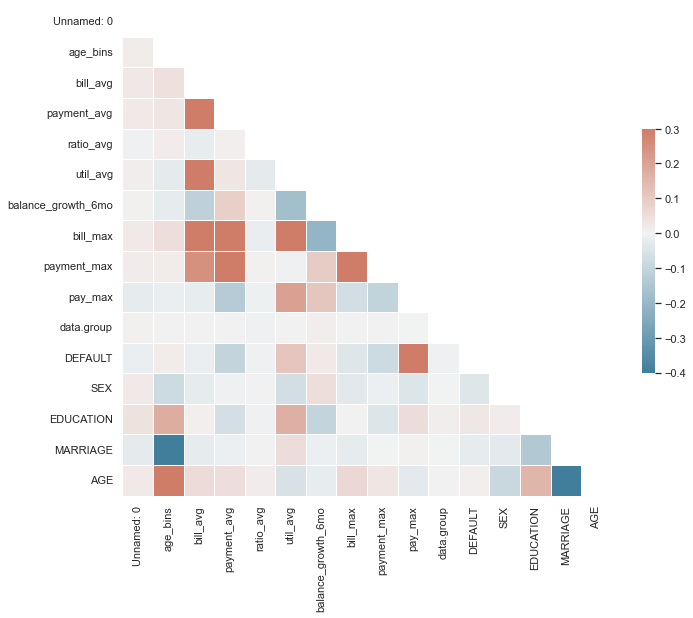

In [14]:

from string import ascii_letters
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")


# Compute the correlation matrix
credit_card_default_final = pd.read_csv('./Data/credit_card_default_final.csv')
corr = credit_card_default_final.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [15]:
# apply optimial binning
credit_card_default['AGE']=pd.cut(credit_card_default['AGE'], bins=[0, 25, 35, 45, 100], labels=[1,2,3,4], ordered=True)
credit_card_default['AGE'].value_counts()

2    12938
3     8522
4     4669
1     3871
Name: AGE, dtype: int64

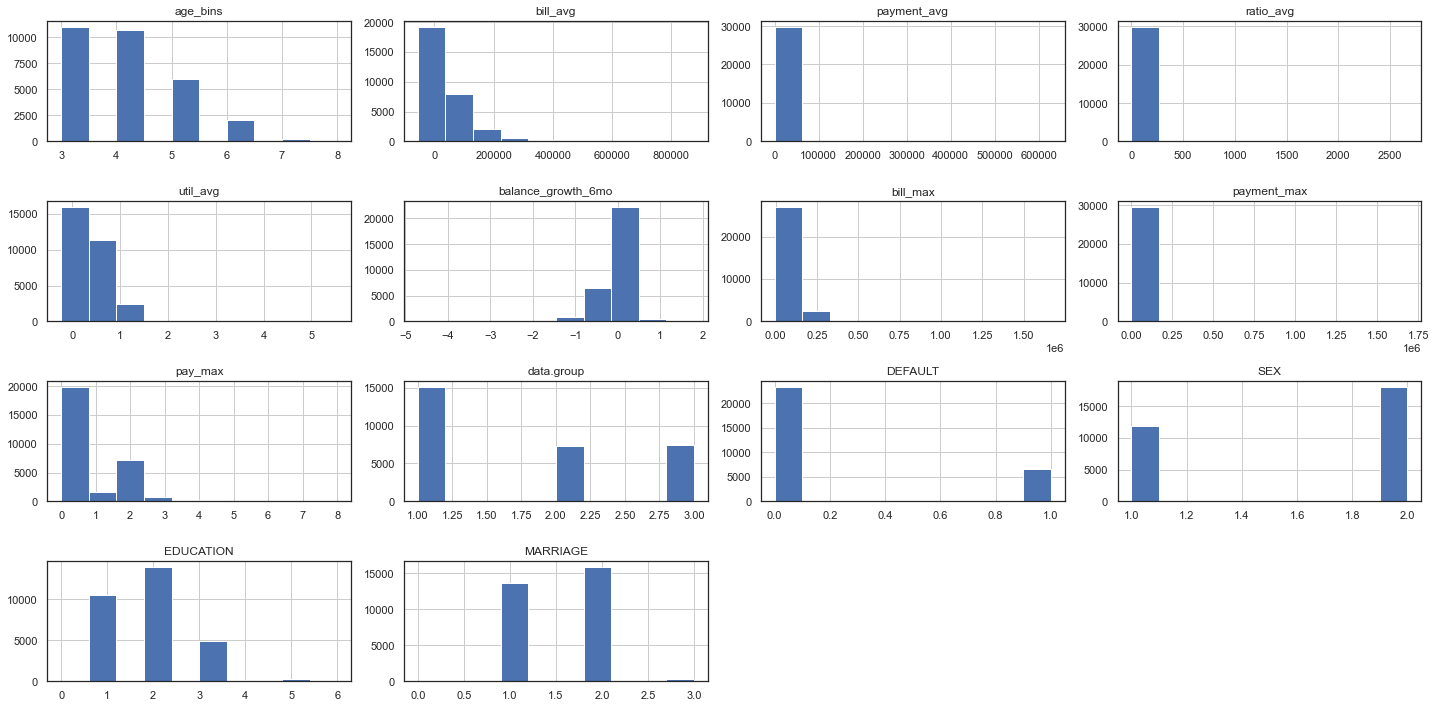

In [16]:
hist = credit_card_default.hist(bins=10, figsize=(20, 10))
plt.tight_layout()


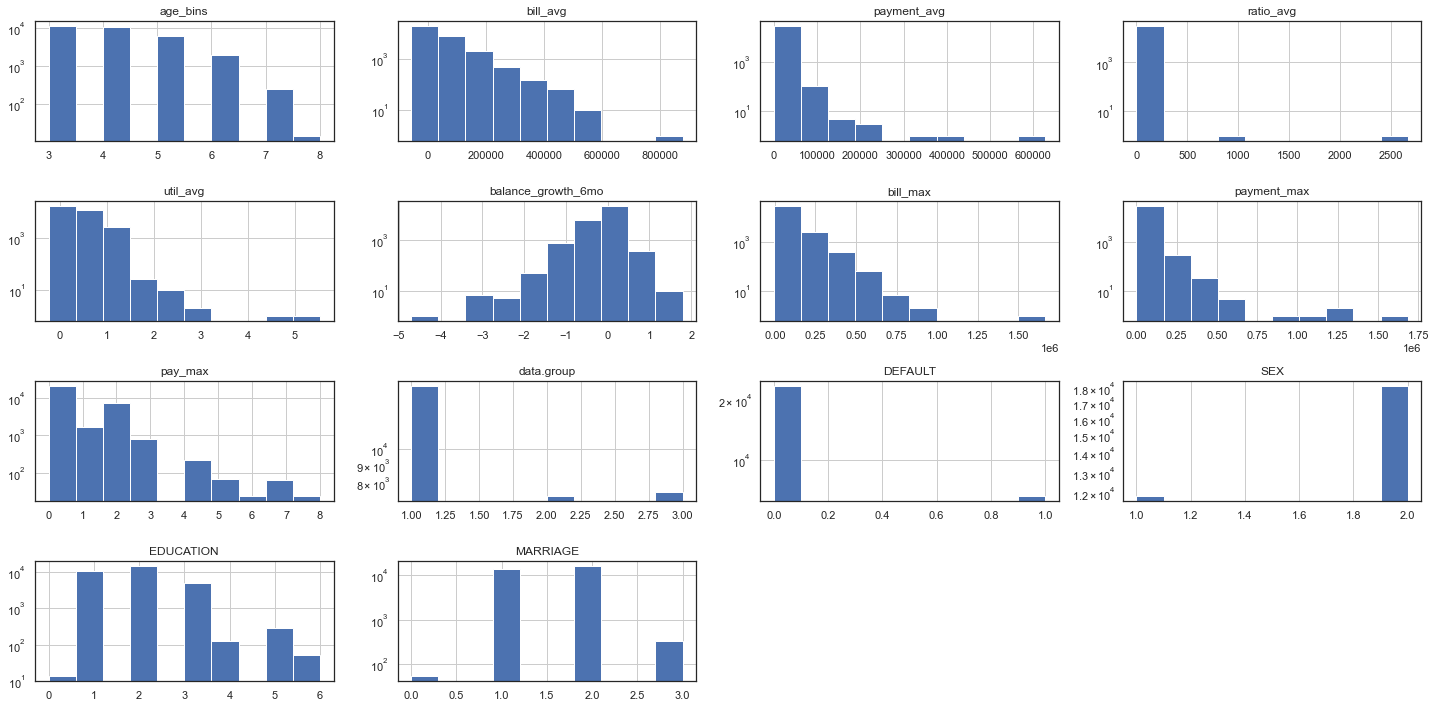

In [17]:
hist = credit_card_default.hist(bins=10, log=True, figsize=(20, 10))
plt.tight_layout()


In [18]:
# reduced based on correlation plot
credit_card_default_red = credit_card_default.drop(columns=['bill_avg', 'ratio_avg', 'balance_growth_6mo', 'bill_max', 'payment_max', 'pay_max', 
                                                        'SEX', 'EDUCATION', 'MARRIAGE', 'AGE'])

In [13]:
credit_card_default_red.columns

Index(['age_bins', 'payment_avg', 'util_avg', 'data.group', 'DEFAULT'], dtype='object')

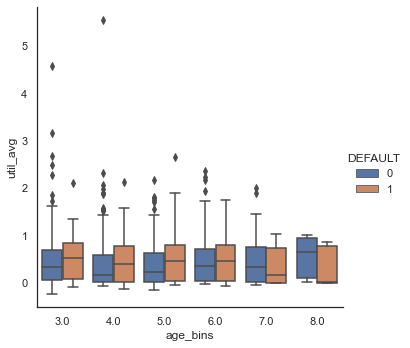

In [33]:

sns.catplot(x='age_bins',y='util_avg', hue='DEFAULT', kind="box", data=credit_card_default_red, ci=None)


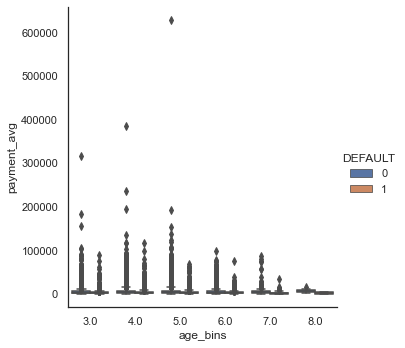

In [34]:

sns.catplot(x='age_bins',y='payment_avg', hue='DEFAULT', kind="box", data=credit_card_default_red, ci=None)



Prep for modeling

In [14]:
ccd_train = credit_card_default[credit_card_default['data.group']==1].drop(columns=['data.group'])
ccd_test = credit_card_default[credit_card_default['data.group']==2].drop(columns=['data.group'])
ccd_validate = credit_card_default[credit_card_default['data.group']==3].drop(columns=['data.group'])

print('train data size:', ccd_train.shape)
print('test data size:', ccd_test.shape)
print('validate data size:', ccd_validate.shape)

train data size: (15180, 14)
test data size: (7323, 14)
validate data size: (7497, 14)


In [15]:
X_train = ccd_train.drop(columns=['DEFAULT'])
X_test = ccd_test.drop(columns=['DEFAULT'])

y_train = ccd_train['DEFAULT']
y_test = ccd_test['DEFAULT']


In [16]:
all_features = X_train.columns
all_features = all_features.tolist()

In [17]:
numerical_features = [c for c, dtype in zip(X_train.columns, X_train.dtypes)
                     if dtype.kind in ['i','f']]
display(numerical_features)
categorical_features = [c for c, dtype in zip(X_train.columns, X_train.dtypes)
                     if dtype.kind not in ['i','f']]
display(categorical_features)

['age_bins',
 'bill_avg',
 'payment_avg',
 'ratio_avg',
 'util_avg',
 'balance_growth_6mo',
 'bill_max',
 'payment_max',
 'pay_max',
 'SEX',
 'EDUCATION',
 'MARRIAGE']

['AGE']

In [18]:
preprocessor = make_column_transformer(
    
    (make_pipeline(
    SimpleImputer(strategy = 'median'),
    # KNNImputer(n_neighbors=2, weights="uniform"),
    MinMaxScaler()), numerical_features),
    
    (make_pipeline(
    SimpleImputer(strategy = 'constant'),  # ValueError: 'fill_value'=missing is invalid. Expected a numerical value when imputing numerical data
    OneHotEncoder(categories = 'auto', handle_unknown = 'ignore')), categorical_features),
    
)

In [19]:
preprocessor_best = make_pipeline(preprocessor, 
                                  VarianceThreshold(), 
                                  SelectKBest(f_classif, k = 'all')
                                 )


5.a RF

In [20]:
model = make_pipeline(preprocessor_best, RandomForestClassifier(n_estimators = 100))
model.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('minmaxscaler',
                                                                                    MinMaxScaler())]),
                                                                   ['age_bins',
                                                                    'bill_avg',
                                                                    'payment_avg',
                                                                    'ratio_avg',
                                                                    'util_avg',
                                                                    'balance_growth_6mo',
                                                                    'bill_max',
                                                                    'payment_max',
                                                                    'pay_max',
                                                                    'SEX',
                                                                    'EDUCATION',
                                                                    'MARRIAGE']),
                                                                  ('pipeline-2',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='constant')),
                                                                                   ('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['AGE'])])),
                                 ('variancethreshold', VarianceThreshold()),
                                 ('selectkbest', SelectKBest(k='all'))])),
                ('randomforestclassifier', RandomForestClassifier())])

,precision,recall,f1-score,support
0,0.83,0.92,0.87,5766.00
1,0.51,0.29,0.37,1557.00
accuracy,0.79,0.79,0.79,0.79
macro avg,0.67,0.61,0.62,7323.00
weighted avg,0.76,0.79,0.77,7323.00


[[5326  440]
 [1107  450]]


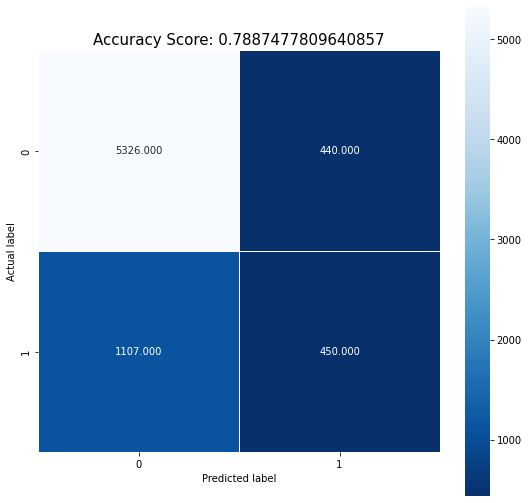

In [21]:
# Ref: https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
predictions = model.predict(X_test)
score = model.score(X_test, y_test)
# print(classification_report(y_test, predictions))
report = classification_report(y_test, predictions, output_dict=True)
df = pd.DataFrame(report).transpose()
display(df.round(2))

cm = confusion_matrix(y_test, predictions)
print(cm)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);


5.b XG

In [22]:
%%time

from xgboost import XGBClassifier
import xgboost as xgb
from xgboost import XGBClassifier
import xgboost as xgb
# model = XGBClassifier(random_state=42, n_jobs=-1, n_estimators=20, max_depth=4, use_label_encoder=False)

model = make_pipeline(preprocessor_best, XGBClassifier(n_estimators = 100))
model.fit(X_train, y_train)

CPU times: total: 5.02 s
Wall time: 880 ms


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('minmaxscaler',
                                                                                    MinMaxScaler())]),
                                                                   ['age_bins',
                                                                    'bill_avg',
                                                                    'payment_avg',
                                                                    'ratio_avg',
                                                                    'util_avg',
                                                                    'balance_growth_6mo',
                                                                    'bill_max',
                                                                    'payment_max',
                                                                    'pay_max',
                                                                    'SEX',
                                                                    'EDUCATION',
                                                                    'MAR...
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=6, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=100, n_jobs=0, num_parallel_tree=1,
                               predictor='auto', random_state=0, reg_alpha=0,
                               reg_lambda=1, ...))])

,precision,recall,f1-score,support
0,0.83,0.93,0.87,5766.00
1,0.51,0.28,0.36,1557.00
accuracy,0.79,0.79,0.79,0.79
macro avg,0.67,0.60,0.62,7323.00
weighted avg,0.76,0.79,0.77,7323.00


[[5340  426]
 [1118  439]]


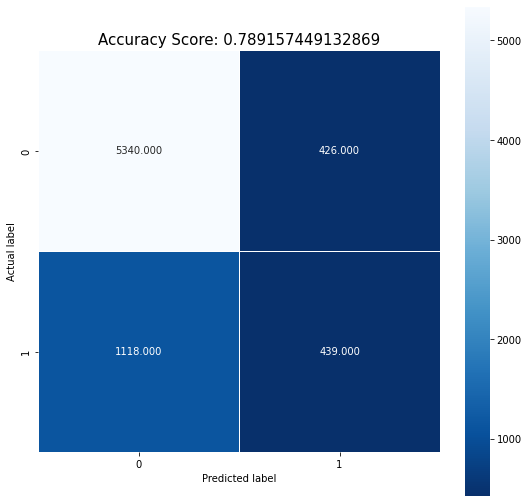

In [23]:
# Ref: https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
predictions = model.predict(X_test)
score = model.score(X_test, y_test)
# print(classification_report(y_test, predictions))
report = classification_report(y_test, predictions, output_dict=True)
df = pd.DataFrame(report).transpose()
display(df.round(2))

cm = confusion_matrix(y_test, predictions)
print(cm)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);


5.c LR

In [24]:
%%time
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

model.fit(X_train, y_train)


CPU times: total: 15.6 ms
Wall time: 27.1 ms


LogisticRegression()

,precision,recall,f1-score,support
0,0.79,0.99,0.88,5766.00
1,0.64,0.03,0.06,1557.00
accuracy,0.79,0.79,0.79,0.79
macro avg,0.72,0.51,0.47,7323.00
weighted avg,0.76,0.79,0.71,7323.00


[[5737   29]
 [1505   52]]


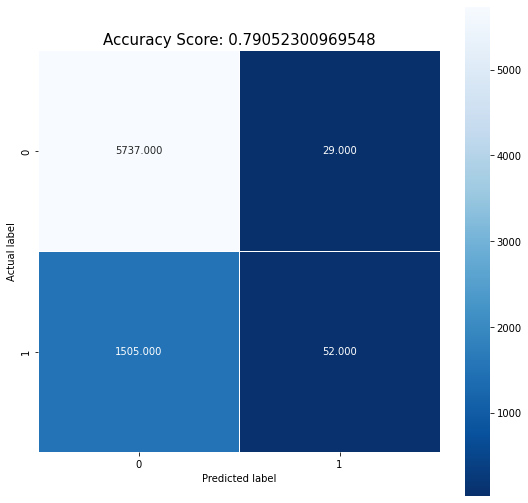

In [25]:
# Ref: https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
predictions = model.predict(X_test)
score = model.score(X_test, y_test)
# print(classification_report(y_test, predictions))
report = classification_report(y_test, predictions, output_dict=True)
df = pd.DataFrame(report).transpose()
display(df.round(2))

cm = confusion_matrix(y_test, predictions)
print(cm)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);


5.d SVM

In [26]:
%timeit
from sklearn import svm
model = svm.SVC(kernel='rbf') 

model.fit(X_train, y_train)

SVC()

c:\Users\steve\miniconda3\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\steve\miniconda3\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\steve\miniconda3\envs\sklearn\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.79,1.00,0.88,5766.00
1,0.00,0.00,0.00,1557.00
accuracy,0.79,0.79,0.79,0.79
macro avg,0.39,0.50,0.44,7323.00
weighted avg,0.62,0.79,0.69,7323.00


[[5766    0]
 [1557    0]]


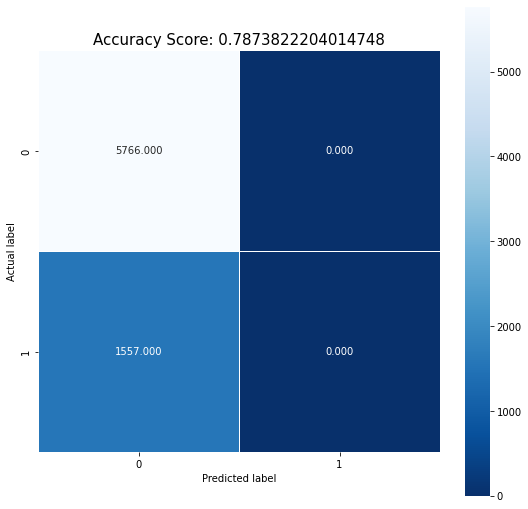

In [27]:
# Ref: https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
predictions = model.predict(X_test)
score = model.score(X_test, y_test)
# print(classification_report(y_test, predictions))
report = classification_report(y_test, predictions, output_dict=True)
df = pd.DataFrame(report).transpose()
display(df.round(2))

cm = confusion_matrix(y_test, predictions)
print(cm)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);


In [28]:
credit_card_default.to_csv('./Data/credit_card_default_final.csv')